In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D,SeparableConv1D, UpSampling1D,BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout, LayerNormalization, MultiHeadAttention, Reshape, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import DepthwiseConv2D, Reshape, Input

def ConvFFNBlock(input_tensor, expansion_ratio, d_model, activation='relu'):
    # Convolutional Feed-Forward Network Block
    x1 = Conv1D(d_model, 1, padding='same')(input_tensor)  # Pointwise Convolution
    x = BatchNormalization()(x1)
    x = Activation(activation)(x)
    x = Conv1D(d_model * expansion_ratio, 3, padding='same')(x)  # Depthwise Convolution
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv1D(d_model, 1, padding='same')(x)  # Pointwise Convolution
    x = BatchNormalization()(x)
    return x + x1  # Add & Normalize (no separate normalization here)
def modernblock(inputs, d_model):
    x=SeparableConv1D(filters=d_model, kernel_size=3, activation='relu', padding='same')(inputs)
    x=ConvFFNBlock(x, expansion_ratio=4, d_model=d_model)
    x=ConvFFNBlock(x, expansion_ratio=8, d_model=d_model)
    return x
def ModernTCN(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x=Conv1D(32, 3, strides=2,padding='same')(inputs)
    x = modernblock(x, 64)
    #print(x.shape)
    x= MaxPooling1D(pool_size=2, padding='same')(x)
    x = modernblock(x, 128)
    #print(x.shape)
    x= MaxPooling1D(pool_size=2, padding='same')(x)
    x = modernblock(x, 256)
    #print(x.shape)
    # 全局平均池化和分类头
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = ModernTCN((4500, 1), 4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2250, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 2250, 64)     2208        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2250, 64)     4160        separable_conv1d[0][0]           
______________________________________________________________________________________________

In [5]:
import tensorflow as tf

def weighted_crossentropy(weights):
    def loss(y_true, y_pred):
        # 计算未加权的交叉熵损失
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        # 应用类别权重
        weighted_loss = unweighted_loss * weights
        # 返回加权损失
        return weighted_loss
    return loss
class_weights = [1.0, 2.0, 1.5, 1.0, 2.0] 

In [6]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss=weighted_crossentropy(class_weights), metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
110/110 [==============================] - 76s 522ms/step - loss: 1.3992 - accuracy: 0.6067 - val_loss: 1.5750 - val_accuracy: 0.5815
Epoch 2/80
110/110 [==============================] - 51s 464ms/step - loss: 1.1458 - accuracy: 0.6579 - val_loss: 1.1743 - val_accuracy: 0.6381
Epoch 3/80
110/110 [==============================] - 51s 465ms/step - loss: 1.0803 - accuracy: 0.6747 - val_loss: 1.1670 - val_accuracy: 0.6420
Epoch 4/80
110/110 [==============================] - 51s 467ms/step - loss: 1.0496 - accuracy: 0.6859 - val_loss: 1.0732 - val_accuracy: 0.6937
Epoch 5/80
110/110 [==============================] - 51s 466ms/step - loss: 1.0320 - accuracy: 0.6971 - val_loss: 1.2631 - val_accuracy: 0.6060
Epoch 6/80
110/110 [==============================] - 51s 464ms/step - loss: 0.9935 - accuracy: 0.7068 - val_loss: 1.1328 - val_accuracy: 0.6452
Reduced learning rate to 0.00010000000474974513.
Epoch 7/80
110/110 [==============================] - 51s 465ms/step - loss: 0.91

In [7]:
evaluate_model(model,X_test,y_test)

Precision: 0.7293575968835756
Recall: 0.6378475591840476
F1 Score: 0.6690756759715643
Accuracy: 0.7711182622687047
Class 1 - Precision: 0.7433628318584071, Recall: 0.7400881057268722, F1 Score: 0.7417218543046358
Class 2 - Precision: 0.7917146144994246, Recall: 0.91672218520986, F1 Score: 0.849644952145724
Class 3 - Precision: 0.7156862745098039, Recall: 0.494579945799458, F1 Score: 0.5849358974358974
Class 4 - Precision: 0.6666666666666666, Recall: 0.4, F1 Score: 0.5
Class 1 Accuracy: 0.9529364440868866
Class 2 Accuracy: 0.8041029766693484
Class 3 Accuracy: 0.7916331456154465
Class 4 Accuracy: 0.9935639581657281


In [8]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

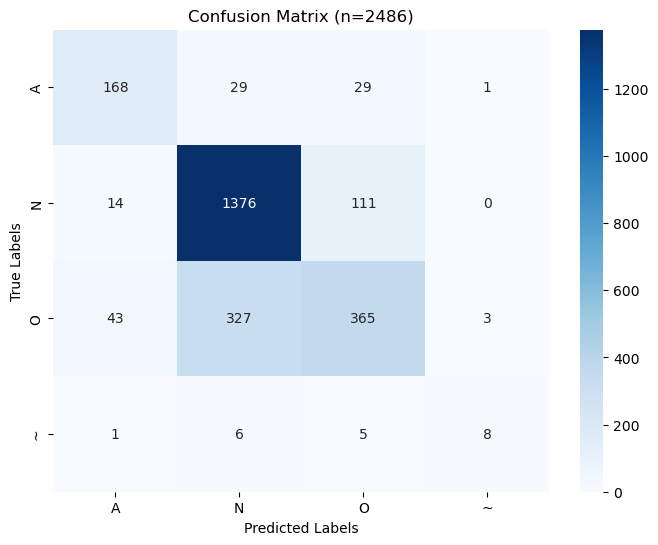

In [9]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])